# K-means 
---

This is an example routine to perform k-means on an IRIS-like raster.

## Modules

In [12]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing

# Scipy
from scipy.stats import norm

# Extras
import time
import warnings
warnings.simplefilter("ignore")

## Functions

In [13]:
def gaussian(x, mu, sig):
    """
        Gaussian definition.
    """
    return (1.0/(sig*np.sqrt(2.0*np.pi)))*np.exp( -0.5*((x-mu)/sig)**2.0 )


def mgii_profiles(xx):
    """
        Function to create 8 artificial kind of Mg II h&k profiles 
        
    """
    wk0  = 2796.2
    wk1  = 2796.8
    wk2  = 2803.2
    wk3  = 2803.8
    wcc  = 2800.0

    sig1 = 0.2
    sig2 = 0.5
    sig3 = 0.1
    sigc = 2
    
    f1   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    f2   = gaussian(xx, wk0, sig2) + gaussian(xx, wk1, sig2) + \
    gaussian(xx, wk2, sig2) + gaussian(xx, wk3, sig2) + gaussian(xx, wcc, sigc)
    f3   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig2) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig2) + gaussian(xx, wcc, sigc)
    f4   = gaussian(xx, wk0, sig2) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig2) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    f5   = gaussian(xx, wk0, sig3) + gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig3) + gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f6   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f7   = gaussian(xx, wk0, sig3) + 0.8*gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig3) + 0.8*gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f8   = gaussian(xx, wk0, sig3) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig3) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    
    return np.stack((f1, f2, f3, f4, f5, f6, f7, f8))

##  Artificial IRIS raster

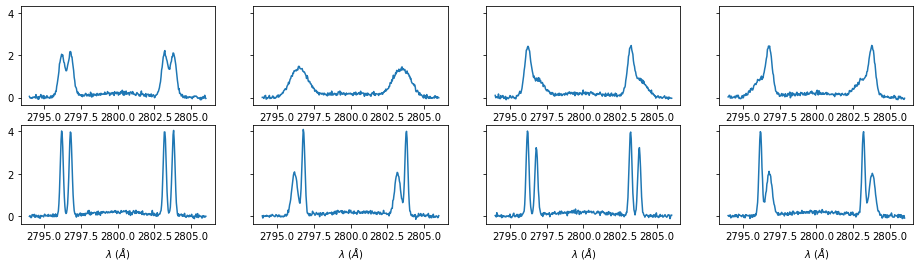

In [14]:
"""
    We create an artificial IRIS raster with eight kind of Mg II h&k profiles
"""
# 1. Wavelength aray and array with 8 kind of Mg II h&k profiles
nprof    = 8                           # Number of profiles [If you change it, you need to change mgii_profile routine]
nw       = 324                         # Number of elements for the wavelength array
wi       = 2794                        # Lower limit of the wavelength array
wf       = 2806                        # Upper limit of the wavelength array
iris_wl  = np.linspace(wi, wf, num=nw) # Wavelength array
ff       = mgii_profiles(iris_wl)      # Array with 8 different Mg II h&k profiles

# 2. Raster separating the 8 profiles in different regions and adding noise to each profile so they are not identical
nx       = 64                          # X size of the IRIS raster
xx       = np.arange(nx)               # Array for the X coordinate
ny       = 108                         # Y size of the IRIS raster
yy       = np.arange(ny)               # Array for the Y coordinate
raster_m = np.zeros((nx, ny, nw))      # IRIS raster
noise    = 0.05
ll       = -1
for ii in range(nx):
    if (ii % nprof == 0):
        ll+=1 
    for jj in range(ny):
        raster_m[ii,jj,:] = ff[ll] + noise*norm.ppf(np.random.rand(nw))


# 3. Plot an example of each kind of profile
nrow = 2    # Number of rows for the plots
ncol = 4    # Number of columns for the plots
fig, axs = plt.subplots(nrow,ncol,figsize=(16,4), facecolor='white', sharey=True)
for kk in range(nprof):
    axs.flat[kk].set_xlabel(r"$\lambda$ ($\AA$)")
    axs.flat[kk].plot(iris_wl,raster_m[nprof*kk,100,:])
plt.show()

## Pre-processing
We reshape the raster-arrays and scale the data for the k-means method. 

In [15]:
data   = raster_m.reshape(raster_m.shape[0]*raster_m.shape[1],raster_m.shape[2])
scaler = preprocessing.StandardScaler().fit(data)
data_s = scaler.transform(data)

## PCA 
We can also reduce the dimensionality of the problem through Principal Component Analysis (PCA)

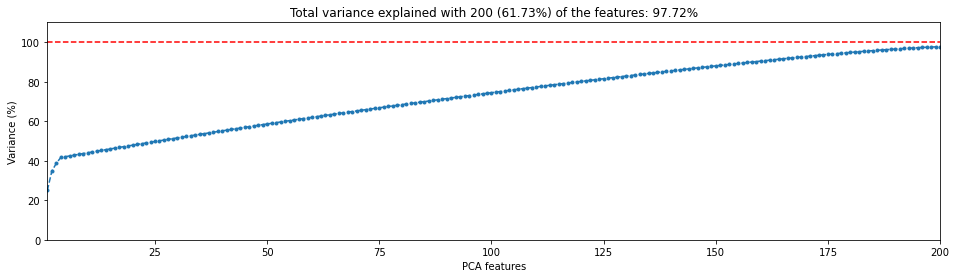

In [16]:
do_pca = True

if (do_pca):
    n_components = 200
    pca = PCA(n_components=n_components)
    data_s = pca.fit_transform(data_s)

    features = range(1,n_components+1)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,4),facecolor='white')
    variance_per=((pca.explained_variance_ratio_).cumsum())*100
    axs.plot(features, variance_per, marker = '.', linestyle='--')
    axs.set_xlabel('PCA features')
    axs.set_ylabel('Variance (%)')
    axs.set_ylim([0,110])
    axs.set_xlim([1,n_components])
    axs.hlines(y=100, xmin=1,xmax=n_components, color='r', linestyle='--')
    axs.set_title('Total variance explained with '+
                  str(n_components)+' ({0:.2f}%)'.format(100*n_components/nw)+
                  ' of the features: {0:.2f}%'.format(variance_per[-1]))
    plt.show()

## K-means


In [17]:
"""
    K-Means
"""
n_clusters   = 8   # Number of clusters to find
n_init       = 100 # Number of time the k-means algorithm will be run with different centroid seeds. 
                   # The final results will be the best output of n_init consecutive runs in terms of inertia.
random_state = 10  # Determines random number generation for centroid initialization. 
                   # Use an int to make the randomness deterministic.

start  = time.time()
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, 
                n_init=n_init, random_state=random_state).fit(data_s)
end    = time.time()
print('Time used by KMeans: {0:.3} s'.format(end - start))

Time used by KMeans: 2.82 s


## Labels map

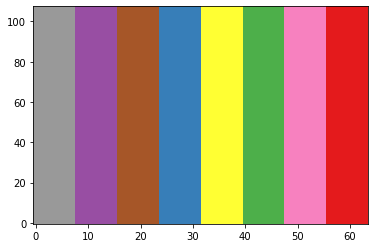

In [18]:
#------------------------------------------------------------------------
# CLUSTERS, LABELS and INERTIA
#------------------------------------------------------------------------

#Clusters and labels
if (do_pca): 
    clusters_pca = pca.inverse_transform(kmeans.cluster_centers_)
    clusters = scaler.inverse_transform(clusters_pca)
else:
    clusters = scaler.inverse_transform((kmeans.cluster_centers_))

labels   = (kmeans.labels_).reshape(raster_m.shape[0],raster_m.shape[1])
inertia  = kmeans.inertia_

#------------------------------------------------------------------------
# SORTED CLUSTERS AND LABELS
#------------------------------------------------------------------------
# We compute the number of profiles in each cluster (labels_length)
# and the percentage of  profiles in each cluster with respect to the 
# total number of profiles (clusters_per). Then we sorted the clusters
# taking into account the percentage in descending order 
# (clusters_sorted). We also compute the most similar/differnt profile 
# (most_sim/most_dif) to the mean profile (raster_k_mean) and the
# median profile of each cluster (raster_k_median).
labels_length = np.zeros(n_clusters)
labels_s      = 0.0*labels
raster_s      = 0.0*raster_m
clusters_per  = np.zeros(n_clusters)
clusters_s    = np.zeros([n_clusters, nw]) 

most_sim        = np.zeros([n_clusters,nw])
most_dif        = np.zeros([n_clusters,nw])
raster_k_mean   = np.zeros([n_clusters,nw])
raster_k_median = np.zeros([n_clusters,nw])
most_dif_loc    = np.zeros([n_clusters,2])
most_sim_loc    = np.zeros([n_clusters,2])


for k in range(n_clusters):
    labels_length[k] = len(labels[labels==k])
    clusters_per[k]  = 100*labels_length[k]/labels.size
clusters_sorted = np.argsort(clusters_per)[::-1] 
for k in range(n_clusters):
    clusters_s[k,:] = clusters[clusters_sorted[k],:]
    labels_s[labels==clusters_sorted[k]] = k
    
    raster_k             = raster_m[labels==clusters_sorted[k]]
    raster_k_mean[k,:]   = np.mean(raster_k,   axis=0)
    raster_k_median[k,:] = np.median(raster_k, axis=0)
    val_most_dif = 0.0
    val_most_sim = 1e6
    for j in range(raster_k.shape[0]):
            temp_std = np.std(((raster_k[j,:]-raster_k_mean[k,:])))
            temp_max = np.max(np.abs(((raster_k[j,:]-raster_k_mean[k,:])/(raster_k_mean[k,:]+raster_k[j,:]))))
            if (temp_std > val_most_dif):
                most_dif[k,:] = raster_k[j,:]
                val_most_dif = temp_std
            if (temp_std < val_most_sim):
                most_sim[k,:] = raster_k[j,:]
                val_most_sim = temp_std
    
plt.pcolormesh(xx,yy,labels_s.T,cmap="Set1")
plt.show()

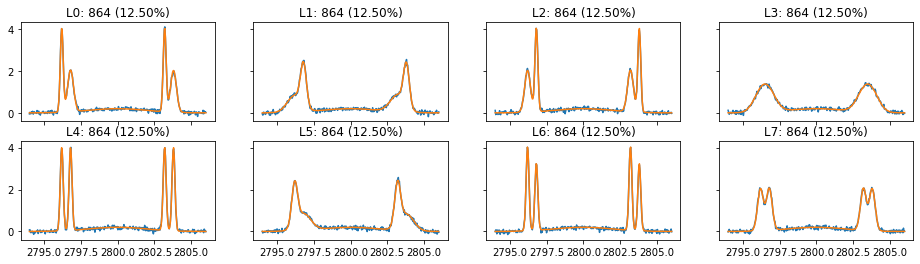

In [19]:
"""
    We plot the most different profile and the representative profiles
"""
fig, axs = plt.subplots(2,ncol,figsize=(16,4), facecolor='white',sharex=True, sharey=True)
t_title = 'L{}: {} ({:.2f}%)'
for kk in range(n_clusters):
    axs.flat[kk].plot(iris_wl,most_dif[kk,:])
    axs.flat[kk].plot(iris_wl,clusters_s[kk,:])
    axs.flat[kk].set_title(t_title.format(str(kk),
                                         str(int(labels_length[clusters_sorted[kk]])),
                                         clusters_per[clusters_sorted[kk]]))
plt.show()



## Convergence of the k-means method
We can check the convergence of the k-means method studying the inertia for different number of clusters.

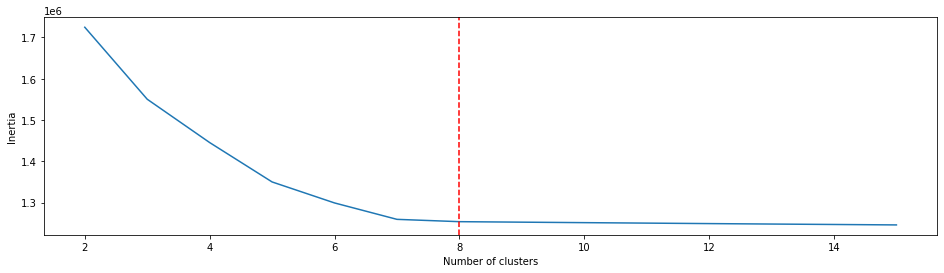

In [20]:
n_test_clusters=n_clusters*2
sse={}

for k in range(2,n_test_clusters):
    temp   = KMeans(n_clusters=k, 
                    n_init=n_init, random_state=random_state).fit(data_s)
    sse[k] = temp.inertia_
    slabel = temp.labels_    
    sse_x  = np.array(list(sse.keys()))
    sse_y  = np.array(list(sse.values()))

fig, axs = plt.subplots(1, 1,figsize=(16,4),facecolor='white')
axs.plot(sse_x,sse_y)
axs.axvline(n_clusters, color='r', linestyle='--')
axs.set_xlabel("Number of clusters")
axs.set_ylabel("Inertia")
plt.show()

## Inertia per cluster

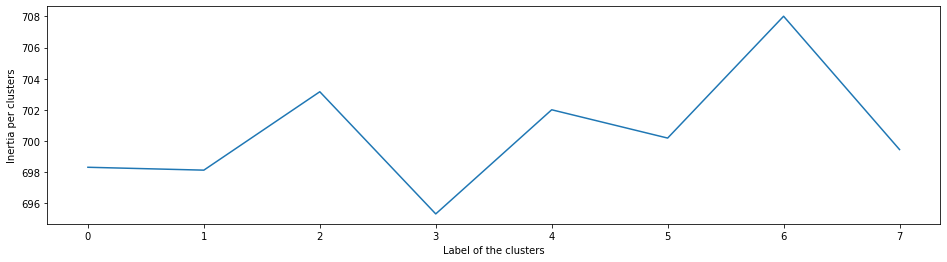

In [21]:
intertia_per_cluster = np.zeros(n_clusters)
cardinality          = np.zeros(n_clusters)
for i in range(n_clusters):
    cardinality[i] = raster_m[labels_s == i, :].shape[0]
    intertia_per_cluster[i]=np.sum((raster_m[labels_s == i, :] - clusters_s[i, :])**2.0)

fig, axs = plt.subplots(1, 1,figsize=(16,4),facecolor="white")  
axs.set_xlabel("Label of the clusters")
axs.set_ylabel("Inertia per clusters")
axs.plot(range(n_clusters),intertia_per_cluster)

plt.show()